---------- Timestep 0 ----------
Entropy at timestep 0: 1.0710618424896237
Agent 1: Position(5.171, 2.020), Velocity(0.009, -0.000)
Agent 2: Position(15.249, 1.700), Velocity(-0.009, 0.000)
---------- Timestep 1 ----------
Entropy at timestep 1: 1.0728888408902764
Agent 1: Position(5.373, 2.020), Velocity(0.017, -0.000)
Agent 2: Position(15.085, 1.700), Velocity(-0.017, 0.000)
---------- Timestep 2 ----------
Entropy at timestep 2: 1.2040201214800947
Agent 1: Position(6.336, 2.030), Velocity(3.683, 0.047)
Agent 2: Position(14.162, 1.700), Velocity(3.314, 0.000)
---------- Timestep 3 ----------
Entropy at timestep 3: 1.210138130272803
Agent 1: Position(6.673, 2.021), Velocity(3.809, 0.288)
Agent 2: Position(13.943, 1.700), Velocity(3.084, 0.000)
---------- Timestep 4 ----------
Entropy at timestep 4: 1.2415363192498932
Agent 1: Position(7.643, 2.117), Velocity(4.637, 0.524)
Agent 2: Position(13.091, 1.700), Velocity(4.420, 0.010)
---------- Timestep 5 ----------
Entropy at timestep 5: 1

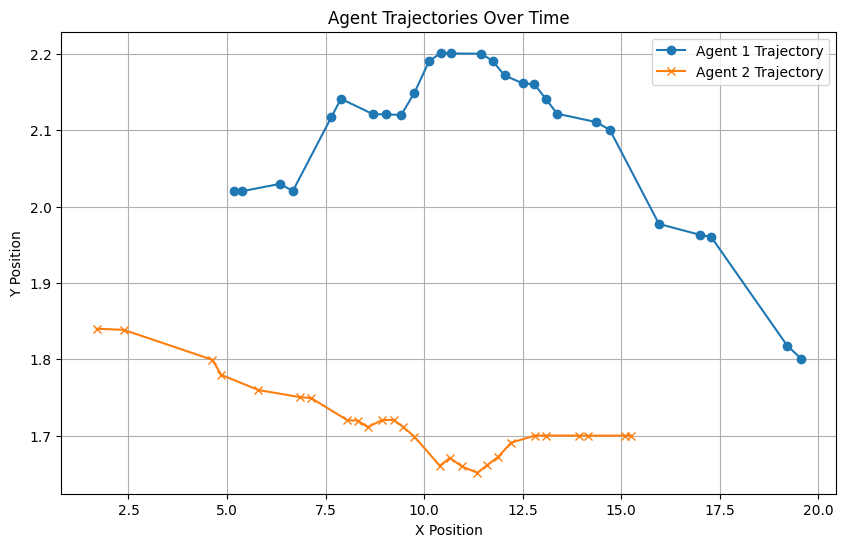

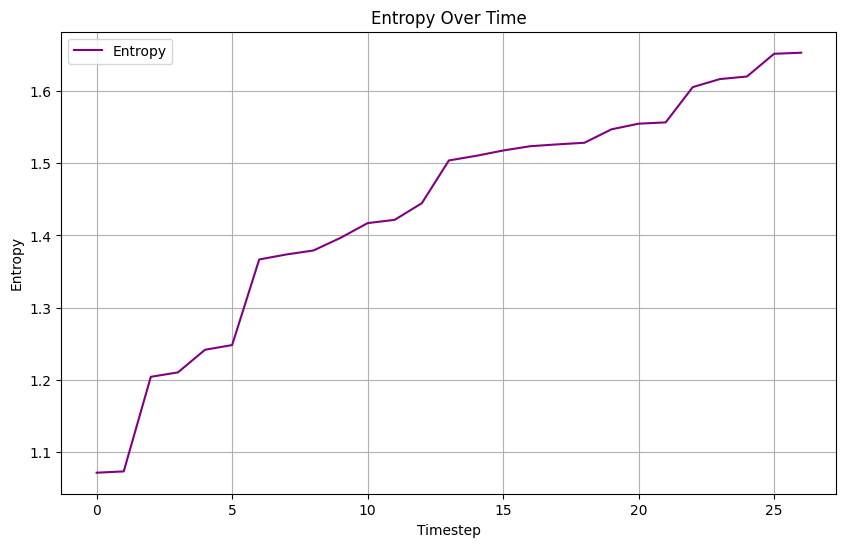

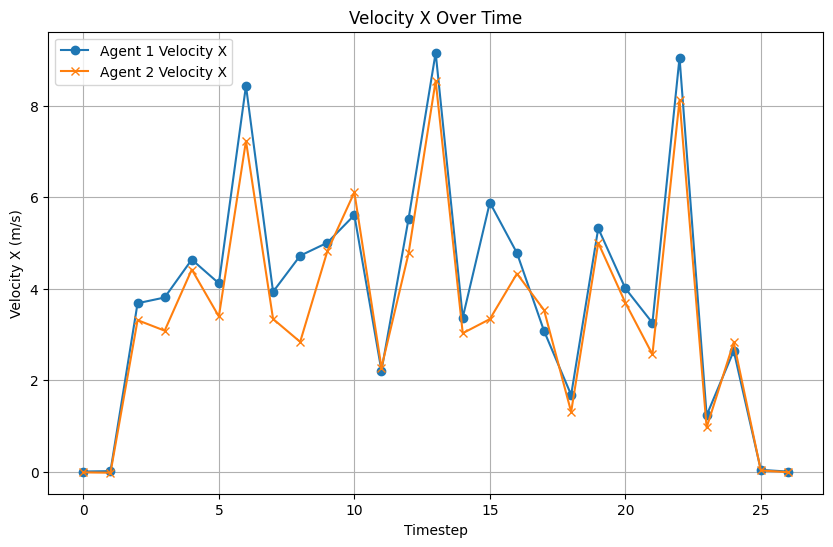

In [8]:
import numpy as np
import csv
import math
import sys
import matplotlib.pyplot as plt
from collections import deque   

# Constants
NUM_AGENTS = 2
ENSEMBLE_SIZE = 2000
STATE_SIZE = 4  # [x, y, v_x, v_y]
MAX_ITERATIONS = 27
NOISE_STD = 0.05  # Reduced from 0.5 to minimize velocity fluctuations
ENV_SIZE = 20.0  # Increased environment size to accommodate agent movements

# Additional Constants for Stability
MAX_VELOCITY = 3.0  # Maximum allowed velocity (m/s)

# Ensemble Kalman Smoother Parameters
ENKS_WINDOW_SIZE = 5

# Social Force Model Parameters (Literature Values)
A = 2.1        # Interaction strength between pedestrians (m^2/s^2)
B = 0.3        # Distance decay for repulsion (meters)
C = 10.0       # Interaction strength with walls (m^2/s^2)
D = 0.2        # Distance decay for boundary repulsion (meters)
V0 = 1.5       # Desired speed (m/s)
TAU = 0.5      # Relaxation time (s)
MASS = 1.0     # Agent mass (kg)
DT = 0.125     # Time step (s)
MAX_FORCE = 10000.0  # Maximum allowable force to ensure numerical stability

# Define the state structure for each agent
class AgentState:
    def __init__(self, x_pos, y_pos, v_x, v_y):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.v_x = v_x
        self.v_y = v_y

# Define a structure to hold target positions
class TargetPosition:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y

# Function to load CSV data
def load_csv(file_path):
    agent1_data = []
    agent2_data = []
    try:
        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                agent1_state = AgentState(
                    x_pos=float(row['x_pos_1']),
                    y_pos=float(row['y_pos_1']),
                    v_x=float(row['v_x1']),
                    v_y=float(row['v_y1'])
                )
                agent2_state = AgentState(
                    x_pos=float(row['x_pos_2']),
                    y_pos=float(row['y_pos_2']),
                    v_x=float(row['v_x2']),
                    v_y=float(row['v_y2'])
                )
                agent1_data.append(agent1_state)
                agent2_data.append(agent2_state)
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        sys.exit(-1)
    except KeyError as e:
        print(f"Error: Missing column in CSV file: {e}")
        sys.exit(-1)
    except ValueError as e:
        print(f"Error: Invalid data format: {e}")
        sys.exit(-1)
    return agent1_data, agent2_data

# Function to calculate desired velocity
def calculate_desired_velocity(agent, target):
    dx = target.x - agent.x_pos
    dy = target.y - agent.y_pos
    distance = math.sqrt(dx**2 + dy**2)
    if distance == 0:
        return np.array([0.0, 0.0])
    return V0 * np.array([dx / distance, dy / distance])

# Function to calculate repulsive force between two agents
def calculate_repulsive_force(agent, other):
    dx = agent.x_pos - other.x_pos
    dy = agent.y_pos - other.y_pos
    distance = math.sqrt(dx**2 + dy**2)
    if distance == 0:
        return np.array([0.0, 0.0])
    force_magnitude = A * math.exp(-distance / B)
    return force_magnitude * np.array([dx / distance, dy / distance])

# Function to calculate repulsive force from boundaries
def calculate_boundary_repulsive_force(agent):
    force = np.array([0.0, 0.0])
    
    # Left boundary
    distance = agent.x_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([1.0, 0.0])
    
    # Right boundary
    distance = ENV_SIZE - agent.x_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([-1.0, 0.0])
    
    # Bottom boundary
    distance = agent.y_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([0.0, 1.0])
    
    # Top boundary
    distance = ENV_SIZE - agent.y_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([0.0, -1.0])
    
    return force

# Function to update agents using Social Force Model with Velocity Clamping
def update_agents_sfm(current_states, targets, dt=DT):
    total_forces = [np.array([0.0, 0.0]) for _ in range(NUM_AGENTS)]
    for i in range(NUM_AGENTS):
        # Desired force to reach target
        desired_velocity = calculate_desired_velocity(current_states[i], targets[i])
        current_velocity = np.array([current_states[i].v_x, current_states[i].v_y])
        F_acc = (desired_velocity - current_velocity) / TAU
        total_forces[i] += F_acc
        
        # Repulsive forces from other agents
        for j in range(NUM_AGENTS):
            if i == j:
                continue
            F_rep = calculate_repulsive_force(current_states[i], current_states[j])
            total_forces[i] += F_rep
        
        # Repulsive forces from boundaries
        F_boundary = calculate_boundary_repulsive_force(current_states[i])
        total_forces[i] += F_boundary
        
        # Prevent extremely large forces to ensure numerical stability
        force_magnitude = np.linalg.norm(total_forces[i])
        if force_magnitude > MAX_FORCE:
            total_forces[i] = (total_forces[i] / force_magnitude) * MAX_FORCE
    
    # Update velocities and positions
    for i in range(NUM_AGENTS):
        acceleration = total_forces[i] / MASS
        current_states[i].v_x += acceleration[0] * dt
        current_states[i].v_y += acceleration[1] * dt
        current_states[i].x_pos += current_states[i].v_x * dt
        current_states[i].y_pos += current_states[i].v_y * dt
        
        # Velocity Clamping
        velocity = np.array([current_states[i].v_x, current_states[i].v_y])
        speed = np.linalg.norm(velocity)
        if speed > MAX_VELOCITY:
            current_states[i].v_x, current_states[i].v_y = (velocity / speed) * MAX_VELOCITY
        
        # Boundary conditions (torus)
        if current_states[i].x_pos < 0:
            current_states[i].x_pos += ENV_SIZE
        if current_states[i].x_pos > ENV_SIZE:
            current_states[i].x_pos -= ENV_SIZE
        if current_states[i].y_pos < 0:
            current_states[i].y_pos += ENV_SIZE
        if current_states[i].y_pos > ENV_SIZE:
            current_states[i].y_pos -= ENV_SIZE

# Function to calculate entropy
def calculate_entropy(Q_diag):
    state_sz = len(Q_diag)
    det_Q = np.prod(Q_diag)
    
    # Ensure determinant is positive
    if det_Q <= 0.0 or np.isnan(det_Q):
        det_Q = 1e-24
    
    # Calculate entropy using the formula:
    # e(Q_tilda) = 1/2 * (log((2πe)^d * det(Q_tilda)))
    entropy = 0.5 * (np.log((2.0 * math.pi * math.e) ** state_sz) + np.log(det_Q))
    
    # Check for NaN entropy
    if np.isnan(entropy):
        entropy = 0.0
    
    return entropy

# Function to perform Kalman Gain and correction
def kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history):
    state_sz = STATE_SIZE  # [x_pos, y_pos, v_x, v_y]
    
    # Predict Step for Agent 1: P1 = P1 + Q_cov1 (only diagonal elements)
    for i in range(state_sz):
        P1[i][i] += Q_cov1[i]
    
    # Predict Step for Agent 2: P2 = P2 + Q_cov2 (only diagonal elements)
    for i in range(state_sz):
        P2[i][i] += Q_cov2[i]
    
    # Calculate Kalman Gain for Agent 1: K1 = P1 / (P1 + R_cov)
    K1 = np.zeros(state_sz)
    for i in range(state_sz):
        K1[i] = P1[i][i] / (P1[i][i] + R_cov[i][i])
    
    # Calculate Kalman Gain for Agent 2: K2 = P2 / (P2 + R_cov)
    K2 = np.zeros(state_sz)
    for i in range(state_sz):
        K2[i] = P2[i][i] / (P2[i][i] + R_cov[i][i])
    
    # Update ensemble members
    for n in range(ENSEMBLE_SIZE):
        # Agent 1 correction
        ensemble[n][0].x_pos += K1[0] * (agent1_measurement.x_pos - ensemble[n][0].x_pos)
        ensemble[n][0].y_pos += K1[1] * (agent1_measurement.y_pos - ensemble[n][0].y_pos)
        ensemble[n][0].v_x += K1[2] * (agent1_measurement.v_x - ensemble[n][0].v_x)
        ensemble[n][0].v_y += K1[3] * (agent1_measurement.v_y - ensemble[n][0].v_y)
        
        # Agent 2 correction
        ensemble[n][1].x_pos += K2[0] * (agent2_measurement.x_pos - ensemble[n][1].x_pos)
        ensemble[n][1].y_pos += K2[1] * (agent2_measurement.y_pos - ensemble[n][1].y_pos)
        ensemble[n][1].v_x += K2[2] * (agent2_measurement.v_x - ensemble[n][1].v_x)
        ensemble[n][1].v_y += K2[3] * (agent2_measurement.v_y - ensemble[n][1].v_y)
    
    # Update State Covariance P1: P1 = (I - K1) * P1 + Regularization
    for i in range(state_sz):
        P1[i][i] = (1.0 - K1[i]) * P1[i][i] + 1e-6  # Regularization added
    
    # Update State Covariance P2: P2 = (I - K2) * P2 + Regularization
    for i in range(state_sz):
        P2[i][i] = (1.0 - K2[i]) * P2[i][i] + 1e-6  # Regularization added
    
    # Store the updated ensemble for smoothing
    ensemble_snapshot = [[AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member] for ensemble_member in ensemble]
    ensemble_history.append(ensemble_snapshot)
    
    # Ensure the history size does not exceed the window size
    if len(ensemble_history) > ENKS_WINDOW_SIZE:
        ensemble_history.popleft()

# Function to perform Maximum Likelihood Estimation and smoothing
def mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, timestep, Q_cov_history_agent1, Q_cov_history_agent2):
    w = 2  # Window size on each side (total window size = 2w +1 =5)
    total_window = 2 * w + 1

    state_sz = 4  # [x_pos, y_pos, v_x, v_y]

    # Initialize covariance sums for Agent 1 and Agent 2
    sum_Q1 = np.zeros(state_sz)
    sum_Q2 = np.zeros(state_sz)

    # Compute sum of squared differences
    for n in range(ENSEMBLE_SIZE):
        # Differences for Agent 1
        diff1_x = agent1_measurement.x_pos - ensemble[n][0].x_pos
        diff1_y = agent1_measurement.y_pos - ensemble[n][0].y_pos
        diff1_vx = agent1_measurement.v_x - ensemble[n][0].v_x
        diff1_vy = agent1_measurement.v_y - ensemble[n][0].v_y

        # Differences for Agent 2
        diff2_x = agent2_measurement.x_pos - ensemble[n][1].x_pos
        diff2_y = agent2_measurement.y_pos - ensemble[n][1].y_pos
        diff2_vx = agent2_measurement.v_x - ensemble[n][1].v_x
        diff2_vy = agent2_measurement.v_y - ensemble[n][1].v_y

        # Sum squared differences for Agent 1
        sum_Q1[0] += diff1_x ** 2
        sum_Q1[1] += diff1_y ** 2
        sum_Q1[2] += diff1_vx ** 2
        sum_Q1[3] += diff1_vy ** 2

        # Sum squared differences for Agent 2
        sum_Q2[0] += diff2_x ** 2
        sum_Q2[1] += diff2_y ** 2
        sum_Q2[2] += diff2_vx ** 2
        sum_Q2[3] += diff2_vy ** 2

    # Update Q_cov1 and Q_cov2 with averaged values and regularization
    Q_cov1 += (sum_Q1 / ENSEMBLE_SIZE) + 1e-6
    Q_cov2 += (sum_Q2 / ENSEMBLE_SIZE) + 1e-6

    # Ensure Q_cov1 and Q_cov2 are positive
    Q_cov1 = np.where((Q_cov1 < 1e-6) | np.isnan(Q_cov1), 1e-6, Q_cov1)
    Q_cov2 = np.where((Q_cov2 < 1e-6) | np.isnan(Q_cov2), 1e-6, Q_cov2)

    # Add the updated Q_cov to history for both agents
    Q_cov_history_agent1.append(Q_cov1.copy())
    Q_cov_history_agent2.append(Q_cov2.copy())

    # Perform smoothing if enough history is available
    if len(Q_cov_history_agent1) >= total_window and len(Q_cov_history_agent2) >= total_window:
        # Compute the smoothed Q_cov for Agent 1
        smoothed_Q_cov1 = np.mean(np.array(Q_cov_history_agent1)[-total_window:], axis=0)

        # Compute the smoothed Q_cov for Agent 2
        smoothed_Q_cov2 = np.mean(np.array(Q_cov_history_agent2)[-total_window:], axis=0)

        # Assign the smoothed Q_cov vectors
        Q_cov1[:] = smoothed_Q_cov1
        Q_cov2[:] = smoothed_Q_cov2

    # Limit the size of Q_cov_history to total_window
    if len(Q_cov_history_agent1) > total_window:
        Q_cov_history_agent1.popleft()
    if len(Q_cov_history_agent2) > total_window:
        Q_cov_history_agent2.popleft()

    return Q_cov1, Q_cov2

# Main function
def main():
    # Load agent data from CSV
    csv_file_path = "C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\Thesis\\Real world data\\agent_positions_and_velocities_complete.csv"
    agent1_data, agent2_data = load_csv(csv_file_path)
    
    if not agent1_data or not agent2_data:
        print("Error: Agent data is empty. Please check the CSV file.")
        sys.exit(-1)
    
    # Initialize ensemble states
    ensemble = [[AgentState(agent1_data[0].x_pos, agent1_data[0].y_pos, agent1_data[0].v_x, agent1_data[0].v_y),
                AgentState(agent2_data[0].x_pos, agent2_data[0].y_pos, agent2_data[0].v_x, agent2_data[0].v_y)]
                for _ in range(ENSEMBLE_SIZE)]
    
    # Initialize covariance matrices
    P1 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov1 = np.zeros(STATE_SIZE)
    P2 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov2 = np.zeros(STATE_SIZE)
    R_cov = np.zeros((STATE_SIZE, STATE_SIZE))
    
    # Set diagonal elements appropriately for Agent 1 and Agent 2
    for i in range(STATE_SIZE):
        P1[i][i] = 0.1
        Q_cov1[i] = 0.1  # Increased for responsiveness
        P2[i][i] = 0.1
        Q_cov2[i] = 0.1  # Increased for responsiveness
        R_cov[i][i] = 0.005  # Reduced for higher measurement trust
    
    # Initialize Q_cov history for smoothing
    Q_cov_history_agent1 = deque(maxlen=5)  # total_window =5
    Q_cov_history_agent2 = deque(maxlen=5)
    
    # Define target positions (using literature values if necessary)
    targets = [TargetPosition(agent1_data[-1].x_pos, agent1_data[-1].y_pos),
               TargetPosition(agent2_data[-1].x_pos, agent2_data[-1].y_pos)]
    
    # Initialize lists to store positions and other metrics for plotting
    agent1_x_list = []
    agent1_y_list = []
    agent2_x_list = []
    agent2_y_list = []
    entropy_list = []
    velocity_agent1_x = []
    velocity_agent2_x = []
    
    # Open file to save results
    results_file_path = "simulation_results.csv"
    try:
        with open(results_file_path, "w", newline='') as csvfile:
            # fieldnames = ['time', 'agent1_x', 'agent1_y', 'agent2_x', 'agent2_y', 'entropy']
            # writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            # writer.writeheader()
            
            # Initialize ensemble_history for EnKS
            ensemble_history = deque(maxlen=ENKS_WINDOW_SIZE)

            # Main simulation loop
            for t in range(MAX_ITERATIONS):
                print(f"---------- Timestep {t} ----------")
                
                # Step 1: Update agent states using Social Force Model for all ensemble members
                for n in range(ENSEMBLE_SIZE):
                    update_agents_sfm(ensemble[n], targets, dt=DT)
                
                # Step 2: Generate ensemble predictions by adding Gaussian noise
                for n in range(ENSEMBLE_SIZE):
                    for agent_id in range(NUM_AGENTS):
                        ensemble[n][agent_id].x_pos += np.random.normal(0, NOISE_STD)
                        ensemble[n][agent_id].y_pos += np.random.normal(0, NOISE_STD)
                        ensemble[n][agent_id].v_x += np.random.normal(0, NOISE_STD)
                        ensemble[n][agent_id].v_y += np.random.normal(0, NOISE_STD)
                
                # Step 3: Apply Kalman Gain and correction for both agents
                agent1_measurement = agent1_data[t] if t < len(agent1_data) else agent1_data[-1]
                agent2_measurement = agent2_data[t] if t < len(agent2_data) else agent2_data[-1]
                kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov,ensemble_history)
                
                # Step 4: Update covariance matrix Q using MLE and apply smoothing
                mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, t, Q_cov_history_agent1, Q_cov_history_agent2)
                
                # Step 5: Calculate entropy
                entropy1 = calculate_entropy((Q_cov1))
                entropy2 = calculate_entropy((Q_cov2))
                total_entropy = (entropy1 + entropy2) / 2
                entropy_list.append(total_entropy)
                print(f"Entropy at timestep {t}: {total_entropy}")
                
                # Step 6: Save results
                mean_agent1_x = np.mean([ensemble[n][0].x_pos for n in range(ENSEMBLE_SIZE)])
                mean_agent1_y = np.mean([ensemble[n][0].y_pos for n in range(ENSEMBLE_SIZE)])
                mean_agent2_x = np.mean([ensemble[n][1].x_pos for n in range(ENSEMBLE_SIZE)])
                mean_agent2_y = np.mean([ensemble[n][1].y_pos for n in range(ENSEMBLE_SIZE)])
                
                # Append to position lists
                agent1_x_list.append(mean_agent1_x)
                agent1_y_list.append(mean_agent1_y)
                agent2_x_list.append(mean_agent2_x)
                agent2_y_list.append(mean_agent2_y)
                
                # Append velocities for plotting
                velocity_agent1_x.append(np.mean([ensemble[n][0].v_x for n in range(ENSEMBLE_SIZE)]))
                velocity_agent2_x.append(np.mean([ensemble[n][1].v_x for n in range(ENSEMBLE_SIZE)]))
                
                # writer.writerow({
                #     'time': t,
                #     'agent1_x': mean_agent1_x,
                #     'agent1_y': mean_agent1_y,
                #     'agent2_x': mean_agent2_x,
                #     'agent2_y': mean_agent2_y,
                #     'entropy': total_entropy
                # })
                
                # Print agent states (mean of ensemble)
                mean_agent1 = np.array([
                    mean_agent1_x,
                    mean_agent1_y,
                    velocity_agent1_x[-1],
                    np.mean([ensemble[n][0].v_y for n in range(ENSEMBLE_SIZE)])
                ])
                mean_agent2 = np.array([
                    mean_agent2_x,
                    mean_agent2_y,
                    velocity_agent2_x[-1],
                    np.mean([ensemble[n][1].v_y for n in range(ENSEMBLE_SIZE)])
                ])
                
                print(f"Agent 1: Position({mean_agent1[0]:.3f}, {mean_agent1[1]:.3f}), "
                      f"Velocity({mean_agent1[2]:.3f}, {mean_agent1[3]:.3f})")
                print(f"Agent 2: Position({mean_agent2[0]:.3f}, {mean_agent2[1]:.3f}), "
                      f"Velocity({mean_agent2[2]:.3f}, {mean_agent2[3]:.3f})")
                
                # Check if all agents have reached their targets
                all_reached = True
                for agent_id in range(NUM_AGENTS):
                    dx = mean_agent1[0] - targets[agent_id].x if agent_id == 0 else mean_agent2[0] - targets[agent_id].x
                    dy = mean_agent1[1] - targets[agent_id].y if agent_id == 0 else mean_agent2[1] - targets[agent_id].y
                    distance = math.sqrt(dx**2 + dy**2)
                    if distance > 0.1:
                        all_reached = False
                        break
                if all_reached:
                    print("All agents have reached their targets.")
                    break
    except IOError:
        print(f"Error: Could not write to file {results_file_path}.")
        sys.exit(-1)
    
    # Plotting the trajectories after the simulation
    plt.figure(figsize=(10, 6))
    plt.plot(agent1_x_list, agent1_y_list, label='Agent 1 Trajectory', marker='o')
    plt.plot(agent2_x_list, agent2_y_list, label='Agent 2 Trajectory', marker='x')
    plt.title('Agent Trajectories Over Time')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting Entropy vs Time
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(entropy_list)), entropy_list, label='Entropy', color='purple')
    plt.title('Entropy Over Time')
    plt.xlabel('Timestep')
    plt.ylabel('Entropy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting Velocity X vs Time for both agents
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(velocity_agent1_x)), velocity_agent1_x, label='Agent 1 Velocity X', marker='o')
    plt.plot(range(len(velocity_agent2_x)), velocity_agent2_x, label='Agent 2 Velocity X', marker='x')
    plt.title('Velocity X Over Time')
    plt.xlabel('Timestep')
    plt.ylabel('Velocity X (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

---------- Timestep 0 ----------
Entropy at timestep 0: 1.0810804996772068
Agent 1: Position(0.209, 1.360), Velocity(0.049, -0.000)
Agent 2: Position(9.682, 1.360), Velocity(-0.024, 0.000)
---------- Timestep 1 ----------
Entropy at timestep 1: 1.1106495139321
Agent 1: Position(0.224, 1.351), Velocity(0.089, -0.000)
Agent 2: Position(9.674, 1.351), Velocity(-0.046, 0.001)
---------- Timestep 2 ----------
Entropy at timestep 2: 1.1365386337082524
Agent 1: Position(0.204, 1.359), Velocity(0.083, 0.010)
Agent 2: Position(9.674, 1.350), Velocity(-0.045, -0.009)
---------- Timestep 3 ----------
Entropy at timestep 3: 1.1592024592258103
Agent 1: Position(0.224, 1.360), Velocity(0.107, -0.000)
Agent 2: Position(9.674, 1.341), Velocity(-0.044, -0.009)
---------- Timestep 4 ----------
Entropy at timestep 4: 1.134356180794283
Agent 1: Position(0.242, 1.360), Velocity(0.114, 0.009)
Agent 2: Position(9.674, 1.340), Velocity(-0.053, 0.010)
---------- Timestep 5 ----------
Entropy at timestep 5: 1.1

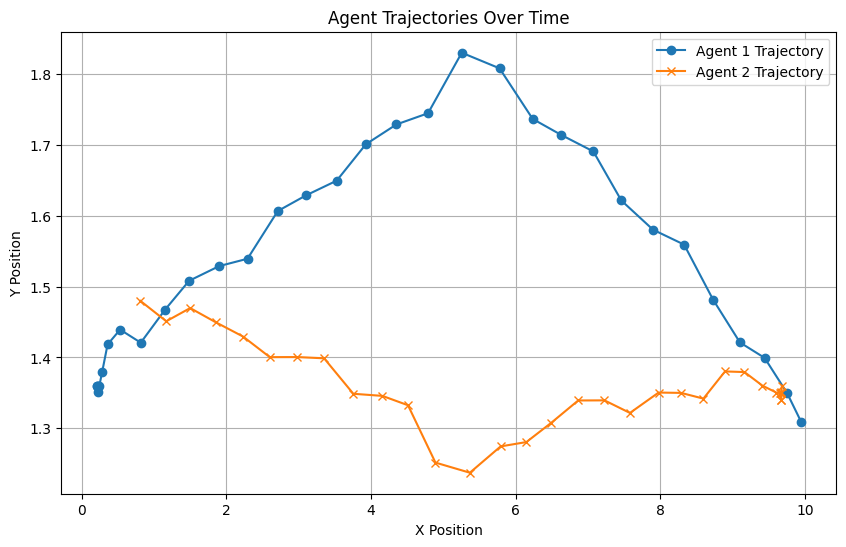

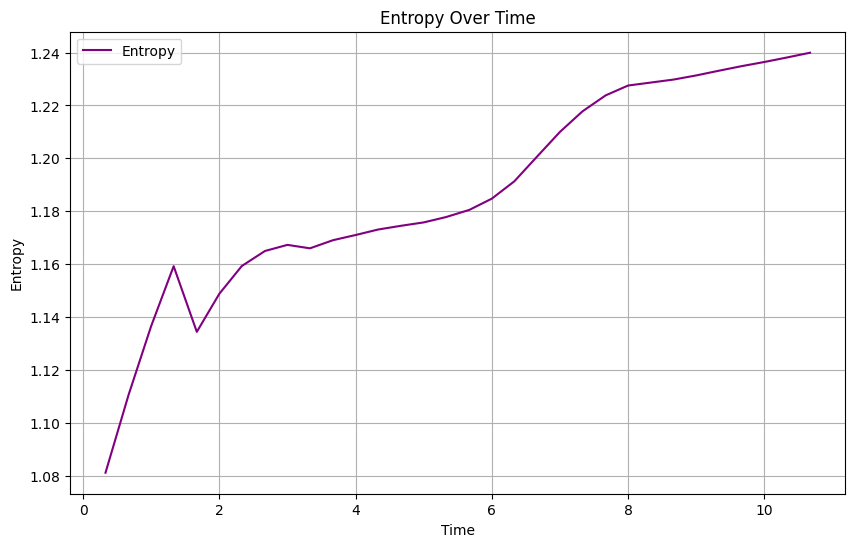

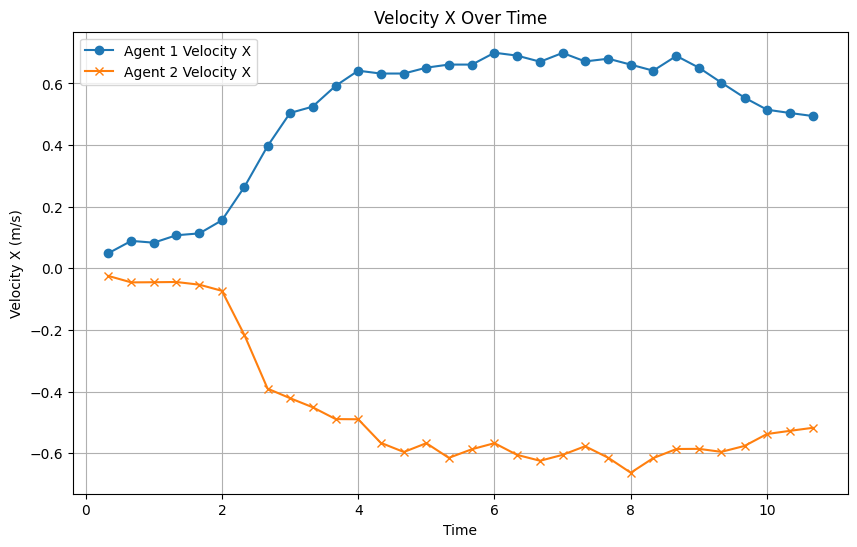

In [ ]:
import numpy as np
import csv
import math
import sys
import matplotlib.pyplot as plt
from collections import deque   

# Constants
NUM_AGENTS = 2
ENSEMBLE_SIZE = 2000
STATE_SIZE = 4  # [x, y, v_x, v_y]
MAX_ITERATIONS = 32
NOISE_STD = 0.1  # Reduced from 0.5 to minimize velocity fluctuations
ENV_SIZE = 20.0  # Increased environment size to accommodate agent movements

# Additional Constants for Stability
MAX_VELOCITY = 2.0  # Maximum allowed velocity (m/s)

# Ensemble Kalman Smoother Parameters
ENKS_WINDOW_SIZE = 5

# Social Force Model Parameters (Literature Values)
A = 2.1        # Interaction strength between pedestrians (m^2/s^2)
B = 0.3        # Distance decay for repulsion (meters)
C = 10.0       # Interaction strength with walls (m^2/s^2)
D = 0.2        # Distance decay for boundary repulsion (meters)
V0 = 1.5       # Desired speed (m/s)
TAU = 0.5      # Relaxation time (s)
MASS = 1.0     # Agent mass (kg)
DT = 0.3333    # Time step (s)
MAX_FORCE = 1000.0  # Maximum allowable force to ensure numerical stability
RAD = 0.2                 # Collision radius

# Define the state structure for each agent
class AgentState:
    def __init__(self, x_pos=0.0, y_pos=0.0, v_x=0.0, v_y=0.0):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.v_x = v_x
        self.v_y = v_y

# Define a structure to hold target positions
class TargetPosition:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y

# Function to load CSV data
def load_csv(file_path):
    timestamps = []
    agent1_data = []
    agent2_data = []
    try:
        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                timestamps.append(float(row['time']))
                agent1_state = AgentState(
                    x_pos=float(row['x_pos_1']),
                    y_pos=float(row['y_pos_1']),
                    v_x=float(row['v_x1']),
                    v_y=float(row['v_y1'])
                )
                agent2_state = AgentState(
                    x_pos=float(row['x_pos_2']),
                    y_pos=float(row['y_pos_2']),
                    v_x=float(row['v_x2']),
                    v_y=float(row['v_y2'])
                )
                agent1_data.append(agent1_state)
                agent2_data.append(agent2_state)
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        sys.exit(-1)
    except KeyError as e:
        print(f"Error: Missing column in CSV file: {e}")
        sys.exit(-1)
    except ValueError as e:
        print(f"Error: Invalid data format: {e}")
        sys.exit(-1)
    return timestamps, agent1_data, agent2_data

# Function to calculate desired velocity
def calculate_desired_velocity(agent, target):
    dx = target.x - agent.x_pos
    dy = target.y - agent.y_pos
    distance = math.sqrt(dx**2 + dy**2)
    if distance == 0:
        return np.array([0.0, 0.0])
    return V0 * np.array([dx / distance, dy / distance])

# Function to calculate repulsive force between two agents
def calculate_repulsive_force(agent, other):
    dx = agent.x_pos - other.x_pos
    dy = agent.y_pos - other.y_pos
    distance = math.sqrt(dx**2 + dy**2)
    if distance == 0:
        return np.array([0.0, 0.0])
    force_magnitude = A * math.exp(-distance / B)
    # Adjust repulsive force based on collision radius
    if distance < 2 * RAD:
        force_magnitude *= (2 * RAD - distance) / (2 * RAD)
    return force_magnitude * np.array([dx / distance, dy / distance])

# Function to calculate repulsive force from boundaries
def calculate_boundary_repulsive_force(agent):
    force = np.array([0.0, 0.0])
    
    # Left boundary
    distance = agent.x_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([1.0, 0.0])
    
    # Right boundary
    distance = ENV_SIZE - agent.x_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([-1.0, 0.0])
    
    # Bottom boundary
    distance = agent.y_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([0.0, 1.0])
    
    # Top boundary
    distance = ENV_SIZE - agent.y_pos
    if 0 < distance < B:
        force += C * math.exp(-distance / D) * np.array([0.0, -1.0])
    
    return force

# Function to update agents using Social Force Model with Velocity Clamping and Collision Avoidance
def update_agents_sfm(current_states, targets, dt=DT):
    total_forces = [np.array([0.0, 0.0]) for _ in range(NUM_AGENTS)]
    for i in range(NUM_AGENTS):
        # Desired force to reach target
        desired_velocity = calculate_desired_velocity(current_states[i], targets[i])
        current_velocity = np.array([current_states[i].v_x, current_states[i].v_y])
        F_acc = (desired_velocity - current_velocity) / TAU
        total_forces[i] += F_acc
        
        # Repulsive forces from other agents
        for j in range(NUM_AGENTS):
            if i == j:
                continue
            F_rep = calculate_repulsive_force(current_states[i], current_states[j])
            total_forces[i] += F_rep
        
        # Repulsive forces from boundaries
        F_boundary = calculate_boundary_repulsive_force(current_states[i])
        total_forces[i] += F_boundary
        
        # Prevent extremely large forces to ensure numerical stability
        force_magnitude = np.linalg.norm(total_forces[i])
        if force_magnitude > MAX_FORCE:
            total_forces[i] = (total_forces[i] / force_magnitude) * MAX_FORCE
    
    # Update velocities and positions
    for i in range(NUM_AGENTS):
        acceleration = total_forces[i] / MASS
        current_states[i].v_x += acceleration[0] * dt
        current_states[i].v_y += acceleration[1] * dt
        current_states[i].x_pos += current_states[i].v_x * dt
        current_states[i].y_pos += current_states[i].v_y * dt
        
        # Velocity Clamping
        velocity = np.array([current_states[i].v_x, current_states[i].v_y])
        speed = np.linalg.norm(velocity)
        if speed > MAX_VELOCITY:
            current_states[i].v_x, current_states[i].v_y = (velocity / speed) * MAX_VELOCITY
        
        # Boundary conditions (torus)
        if current_states[i].x_pos < 0:
            current_states[i].x_pos += ENV_SIZE
        if current_states[i].x_pos > ENV_SIZE:
            current_states[i].x_pos -= ENV_SIZE
        if current_states[i].y_pos < 0:
            current_states[i].y_pos += ENV_SIZE
        if current_states[i].y_pos > ENV_SIZE:
            current_states[i].y_pos -= ENV_SIZE
    
    # Prevent agents from overlapping based on collision radius
    for i in range(NUM_AGENTS):
        for j in range(i + 1, NUM_AGENTS):
            dx = current_states[i].x_pos - current_states[j].x_pos
            dy = current_states[i].y_pos - current_states[j].y_pos
            distance = math.sqrt(dx**2 + dy**2)
            if distance < 2 * RAD and distance != 0:
                overlap = 2 * RAD - distance
                separation = (overlap / 2) * np.array([dx / distance, dy / distance])
                current_states[i].x_pos += separation[0]
                current_states[i].y_pos += separation[1]
                current_states[j].x_pos -= separation[0]
                current_states[j].y_pos -= separation[1]
            elif distance == 0:
                angle = np.random.uniform(0, 2 * math.pi)
                separation = RAD * np.array([math.cos(angle), math.sin(angle)])
                current_states[i].x_pos += separation[0]
                current_states[i].y_pos += separation[1]
                current_states[j].x_pos -= separation[0]
                current_states[j].y_pos -= separation[1]

# Function to calculate entropy
def calculate_entropy(Q_diag):
    state_sz = len(Q_diag)
    det_Q = np.prod(Q_diag)
    
    # Ensure determinant is positive
    if det_Q <= 0.0 or np.isnan(det_Q):
        det_Q = 1e-24
    
    # Calculate entropy using the formula:
    # e(Q_tilda) = 1/2 * (log((2πe)^d * det(Q_tilda)))
    entropy = 0.5 * (math.log((2.0 * math.pi * math.e) ** state_sz) + math.log(det_Q))
    
    # Check for NaN entropy
    if np.isnan(entropy):
        entropy = 0.0
    
    return entropy

# Function to perform Ensemble Kalman Smoother (EnKS)
def ensemble_kalman_smoother(history, ensemble_size, num_agents):
    if not history:
        return []
    
    # Initialize smoothed ensemble with the last ensemble state
    smoothed_ensemble = [[AgentState() for _ in range(num_agents)] for _ in range(ensemble_size)]
    last_ensemble = history[-1]
    for n in range(ensemble_size):
        for agent_id in range(num_agents):
            smoothed_ensemble[n][agent_id].x_pos = last_ensemble[n][agent_id].x_pos
            smoothed_ensemble[n][agent_id].y_pos = last_ensemble[n][agent_id].y_pos
            smoothed_ensemble[n][agent_id].v_x = last_ensemble[n][agent_id].v_x
            smoothed_ensemble[n][agent_id].v_y = last_ensemble[n][agent_id].v_y
    
    # Iterate backwards through the history for smoothing
    for ensemble in reversed(list(history)[:-1]):
        for n in range(ensemble_size):
            for agent_id in range(num_agents):
                smoothed_ensemble[n][agent_id].x_pos = 0.5 * (ensemble[n][agent_id].x_pos + smoothed_ensemble[n][agent_id].x_pos)
                smoothed_ensemble[n][agent_id].y_pos = 0.5 * (ensemble[n][agent_id].y_pos + smoothed_ensemble[n][agent_id].y_pos)
                smoothed_ensemble[n][agent_id].v_x = 0.5 * (ensemble[n][agent_id].v_x + smoothed_ensemble[n][agent_id].v_x)
                smoothed_ensemble[n][agent_id].v_y = 0.5 * (ensemble[n][agent_id].v_y + smoothed_ensemble[n][agent_id].v_y)
    
    return smoothed_ensemble

# Function to perform Kalman Gain and correction
def kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history):
    state_sz = STATE_SIZE  # [x_pos, y_pos, v_x, v_y]
    
    # Predict Step for Agent 1: P1 = P1 + Q_cov1 (only diagonal elements)
    for i in range(state_sz):
        P1[i][i] += Q_cov1[i]
    
    # Predict Step for Agent 2: P2 = P2 + Q_cov2 (only diagonal elements)
    for i in range(state_sz):
        P2[i][i] += Q_cov2[i]
    
    # Calculate Kalman Gain for Agent 1: K1 = P1 / (P1 + R_cov)
    K1 = np.zeros(state_sz)
    for i in range(state_sz):
        K1[i] = P1[i][i] / (P1[i][i] + R_cov[i][i])
    
    # Calculate Kalman Gain for Agent 2: K2 = P2 / (P2 + R_cov)
    K2 = np.zeros(state_sz)
    for i in range(state_sz):
        K2[i] = P2[i][i] / (P2[i][i] + R_cov[i][i])
    
    # Update ensemble members
    for n in range(ENSEMBLE_SIZE):
        # Agent 1 correction
        ensemble[n][0].x_pos += K1[0] * (agent1_measurement.x_pos - ensemble[n][0].x_pos)
        ensemble[n][0].y_pos += K1[1] * (agent1_measurement.y_pos - ensemble[n][0].y_pos)
        ensemble[n][0].v_x += K1[2] * (agent1_measurement.v_x - ensemble[n][0].v_x)
        ensemble[n][0].v_y += K1[3] * (agent1_measurement.v_y - ensemble[n][0].v_y)
        
        # Agent 2 correction
        ensemble[n][1].x_pos += K2[0] * (agent2_measurement.x_pos - ensemble[n][1].x_pos)
        ensemble[n][1].y_pos += K2[1] * (agent2_measurement.y_pos - ensemble[n][1].y_pos)
        ensemble[n][1].v_x += K2[2] * (agent2_measurement.v_x - ensemble[n][1].v_x)
        ensemble[n][1].v_y += K2[3] * (agent2_measurement.v_y - ensemble[n][1].v_y)
    
    # Update State Covariance P1: P1 = (I - K1) * P1 + Regularization
    for i in range(state_sz):
        P1[i][i] = (1.0 - K1[i]) * P1[i][i] + 1e-6  # Regularization added
    
    # Update State Covariance P2: P2 = (I - K2) * P2 + Regularization
    for i in range(state_sz):
        P2[i][i] = (1.0 - K2[i]) * P2[i][i] + 1e-6  # Regularization added
    
    # Store the updated ensemble for smoothing
    ensemble_snapshot = [[AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member] for ensemble_member in ensemble]
    ensemble_history.append(ensemble_snapshot)
    
    # Ensure the history size does not exceed the window size
    if len(ensemble_history) > ENKS_WINDOW_SIZE:
        ensemble_history.popleft()

# Function to perform Maximum Likelihood Estimation and smoothing
def mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, timestep, Q_cov_history_agent1, Q_cov_history_agent2):
    w = 2  # Window size on each side (total window size = 2w +1 =5)
    total_window = 2 * w + 1

    state_sz = 4  # [x_pos, y_pos, v_x, v_y]

    # Initialize covariance sums for Agent 1 and Agent 2
    sum_Q1 = np.zeros(state_sz)
    sum_Q2 = np.zeros(state_sz)

    # Compute sum of squared differences
    for n in range(ENSEMBLE_SIZE):
        # Differences for Agent 1
        diff1_x = agent1_measurement.x_pos - ensemble[n][0].x_pos
        diff1_y = agent1_measurement.y_pos - ensemble[n][0].y_pos
        diff1_vx = agent1_measurement.v_x - ensemble[n][0].v_x
        diff1_vy = agent1_measurement.v_y - ensemble[n][0].v_y

        # Differences for Agent 2
        diff2_x = agent2_measurement.x_pos - ensemble[n][1].x_pos
        diff2_y = agent2_measurement.y_pos - ensemble[n][1].y_pos
        diff2_vx = agent2_measurement.v_x - ensemble[n][1].v_x
        diff2_vy = agent2_measurement.v_y - ensemble[n][1].v_y

        # Sum squared differences for Agent 1
        sum_Q1[0] += diff1_x ** 2
        sum_Q1[1] += diff1_y ** 2
        sum_Q1[2] += diff1_vx ** 2
        sum_Q1[3] += diff1_vy ** 2

        # Sum squared differences for Agent 2
        sum_Q2[0] += diff2_x ** 2
        sum_Q2[1] += diff2_y ** 2
        sum_Q2[2] += diff2_vx ** 2
        sum_Q2[3] += diff2_vy ** 2

    # **Corrected Update: Set Q_cov instead of accumulating**
    Q_cov1 += (sum_Q1 / ENSEMBLE_SIZE) + 1e-4
    Q_cov2 += (sum_Q2 / ENSEMBLE_SIZE) + 1e-4

    # **Ensure Q_cov does not go below a minimum threshold to keep entropy positive**
    min_Q = 1e-4
    Q_cov1 = np.maximum(Q_cov1, min_Q)
    Q_cov2 = np.maximum(Q_cov2, min_Q)

    # Ensure Q_cov1 and Q_cov2 are positive
    Q_cov1 = np.where((Q_cov1 < min_Q) | np.isnan(Q_cov1), min_Q, Q_cov1)
    Q_cov2 = np.where((Q_cov2 < min_Q) | np.isnan(Q_cov2), min_Q, Q_cov2)

    # Add the updated Q_cov to history for both agents
    Q_cov_history_agent1.append(Q_cov1.copy())
    Q_cov_history_agent2.append(Q_cov2.copy())

    # Perform smoothing if enough history is available
    if len(Q_cov_history_agent1) >= total_window and len(Q_cov_history_agent2) >= total_window:
        # Compute the smoothed Q_cov for Agent 1
        smoothed_Q_cov1 = np.mean(np.array(Q_cov_history_agent1)[-total_window:], axis=0)

        # Compute the smoothed Q_cov for Agent 2
        smoothed_Q_cov2 = np.mean(np.array(Q_cov_history_agent2)[-total_window:], axis=0)

        # Assign the smoothed Q_cov vectors, ensuring they are at least min_Q
        smoothed_Q_cov1 = np.maximum(smoothed_Q_cov1, min_Q)
        smoothed_Q_cov2 = np.maximum(smoothed_Q_cov2, min_Q)

        Q_cov1[:] = smoothed_Q_cov1
        Q_cov2[:] = smoothed_Q_cov2

    # Limit the size of Q_cov_history to total_window
    if len(Q_cov_history_agent1) > total_window:
        Q_cov_history_agent1.popleft()
    if len(Q_cov_history_agent2) > total_window:
        Q_cov_history_agent2.popleft()

    return Q_cov1, Q_cov2

# Function to update agent positions based on forces
def update_agents_state(agents, total_forces):
    for i, agent in enumerate(agents):
        a_x = total_forces[i][0] / MASS
        a_y = total_forces[i][1] / MASS
        
        agent.v_x += a_x * DT
        agent.v_y += a_y * DT
        
        agent.x_pos += agent.v_x * DT
        agent.y_pos += agent.v_y * DT

# Main function
def main():
    # Load agent data from CSV
    csv_file_path = "F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\simulation_agent_positions_and_velocities_complete.csv"
    timestamps, agent1_data, agent2_data = load_csv(csv_file_path)
    
    if not agent1_data or not agent2_data:
        print("Error: Agent data is empty. Please check the CSV file.")
        sys.exit(-1)
    
    # Initialize initial states
    initial_states = [
        AgentState(agent1_data[0].x_pos, agent1_data[0].y_pos, agent1_data[0].v_x, agent1_data[0].v_y),
        AgentState(agent2_data[0].x_pos, agent2_data[0].y_pos, agent2_data[0].v_x, agent2_data[0].v_y)
    ]
    
    # Initialize ensemble states
    ensemble = [
        [
            AgentState(agent1_data[0].x_pos, agent1_data[0].y_pos, agent1_data[0].v_x, agent1_data[0].v_y),
            AgentState(agent2_data[0].x_pos, agent2_data[0].y_pos, agent2_data[0].v_x, agent2_data[0].v_y)
        ]
        for _ in range(ENSEMBLE_SIZE)
    ]
    
    # Initialize covariance matrices
    P1 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov1 = np.zeros(STATE_SIZE)
    P2 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov2 = np.zeros(STATE_SIZE)
    R_cov = np.zeros((STATE_SIZE, STATE_SIZE))
    
    # Set diagonal elements appropriately for Agent 1 and Agent 2
    for i in range(STATE_SIZE):
        P1[i][i] = 0.1
        Q_cov1[i] = 0.1  # Increased for responsiveness
        P2[i][i] = 0.1
        Q_cov2[i] = 0.1  # Increased for responsiveness
        R_cov[i][i] = 0.005  # Reduced for higher measurement trust
    
    # Initialize covariance history for smoothing
    Q_cov_history_agent1 = deque(maxlen=5)  # total_window =5
    Q_cov_history_agent2 = deque(maxlen=5)
    
    # Initialize ensemble history for Kalman Gain and Correction
    ensemble_history = deque(maxlen=ENKS_WINDOW_SIZE)
    
    # Define target positions 
    targets = [
        TargetPosition(agent1_data[-1].x_pos, agent1_data[-1].y_pos),
        TargetPosition(agent2_data[-1].x_pos, agent2_data[-1].y_pos)
    ]
    
    # Initialize lists to store positions and other metrics for plotting
    agent1_x_list = []
    agent1_y_list = []
    agent2_x_list = []
    agent2_y_list = []
    entropy_list = []
    velocity_agent1_x = []
    velocity_agent2_x = []
    
    # Open file to save results
    results_file_path = r"C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\SFM\simulation_results.csv"
    try:
        with open(results_file_path, mode='w', newline='') as simulated_file:
            fieldnames = ['time', "agent1_x", "agent1_y", "agent1_vx",
                          "agent2_x", "agent2_y", "agent2_vx", 'entropy']
            simulated_writer = csv.DictWriter(simulated_file, fieldnames=fieldnames)
            simulated_writer.writeheader()
            
            # Main simulation loop
            for t in range(MAX_ITERATIONS):
                print(f"---------- Timestep {t} ----------")
                
                # Step 1: Update agent states using Social Force Model for all ensemble members
                for n in range(ENSEMBLE_SIZE):
                    update_agents_sfm(ensemble[n], targets, dt=DT)
                
                # Step 2: Generate ensemble predictions by adding Gaussian noise
                for n in range(ENSEMBLE_SIZE):
                    for agent_id in range(NUM_AGENTS):
                        ensemble[n][agent_id].x_pos += np.random.normal(0, NOISE_STD)
                        ensemble[n][agent_id].y_pos += np.random.normal(0, NOISE_STD)
                        ensemble[n][agent_id].v_x += np.random.normal(0, NOISE_STD)
                        ensemble[n][agent_id].v_y += np.random.normal(0, NOISE_STD)
                
                # Step 3: Apply Kalman Gain and correction for both agents
                agent1_measurement = agent1_data[t] if t < len(agent1_data) else agent1_data[-1]
                agent2_measurement = agent2_data[t] if t < len(agent2_data) else agent2_data[-1]
                kalman_gain_and_correction(
                    agent1_measurement, agent2_measurement,
                    ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history
                )
                
                # Step 4: Update covariance matrix Q using MLE and apply smoothing
                Q_cov1, Q_cov2 = mle_per_agent(
                    agent1_measurement, agent2_measurement,
                    ensemble, Q_cov1, Q_cov2, t,
                    Q_cov_history_agent1, Q_cov_history_agent2
                )
                
                # Step 5: Calculate entropy
                entropy1 = calculate_entropy(Q_cov1)
                entropy2 = calculate_entropy(Q_cov2)
                total_entropy = (entropy1 + entropy2) / 2
                entropy_list.append(total_entropy)
                print(f"Entropy at timestep {t}: {total_entropy}")
                
                # Step 6: Save results
                mean_agent1_x = np.mean([ensemble[n][0].x_pos for n in range(ENSEMBLE_SIZE)])
                mean_agent1_y = np.mean([ensemble[n][0].y_pos for n in range(ENSEMBLE_SIZE)])
                mean_agent2_x = np.mean([ensemble[n][1].x_pos for n in range(ENSEMBLE_SIZE)])
                mean_agent2_y = np.mean([ensemble[n][1].y_pos for n in range(ENSEMBLE_SIZE)])
                
                # Append to position lists
                agent1_x_list.append(mean_agent1_x)
                agent1_y_list.append(mean_agent1_y)
                agent2_x_list.append(mean_agent2_x)
                agent2_y_list.append(mean_agent2_y)
                
                # Append velocities for plotting
                velocity_agent1_x.append(np.mean([ensemble[n][0].v_x for n in range(ENSEMBLE_SIZE)]))
                velocity_agent2_x.append(np.mean([ensemble[n][1].v_x for n in range(ENSEMBLE_SIZE)]))
                
                # Save to CSV
                simulated_writer.writerow({
                    'time': timestamps[t] if t < len(timestamps) else timestamps[-1],
                    'agent1_x': mean_agent1_x,
                    'agent1_y': mean_agent1_y,
                    'agent1_vx': velocity_agent1_x[-1],
                    'agent2_x': mean_agent2_x,
                    'agent2_y': mean_agent2_y,
                    'agent2_vx' : velocity_agent2_x[-1],
                    'entropy': total_entropy
                })
                
                # Print agent states (mean of ensemble)
                mean_agent1 = np.array([
                    mean_agent1_x,
                    mean_agent1_y,
                    velocity_agent1_x[-1],
                    np.mean([ensemble[n][0].v_y for n in range(ENSEMBLE_SIZE)])
                ])
                mean_agent2 = np.array([
                    mean_agent2_x,
                    mean_agent2_y,
                    velocity_agent2_x[-1],
                    np.mean([ensemble[n][1].v_y for n in range(ENSEMBLE_SIZE)])
                ])
                
                print(f"Agent 1: Position({mean_agent1[0]:.3f}, {mean_agent1[1]:.3f}), "
                      f"Velocity({mean_agent1[2]:.3f}, {mean_agent1[3]:.3f})")
                print(f"Agent 2: Position({mean_agent2[0]:.3f}, {mean_agent2[1]:.3f}), "
                      f"Velocity({mean_agent2[2]:.3f}, {mean_agent2[3]:.3f})")
                
                # Step 7: Update the initial states for the next iteration using ensemble average
                initial_states[0].x_pos = mean_agent1_x
                initial_states[0].y_pos = mean_agent1_y
                initial_states[0].v_x = velocity_agent1_x[-1]
                initial_states[0].v_y = np.mean([ensemble[n][0].v_y for n in range(ENSEMBLE_SIZE)])
                
                initial_states[1].x_pos = mean_agent2_x
                initial_states[1].y_pos = mean_agent2_y
                initial_states[1].v_x = velocity_agent2_x[-1]
                initial_states[1].v_y = np.mean([ensemble[n][1].v_y for n in range(ENSEMBLE_SIZE)])
                
                # Check if all agents have reached their targets
                all_reached = True
                for agent_id in range(NUM_AGENTS):
                    dx = initial_states[agent_id].x_pos - targets[agent_id].x
                    dy = initial_states[agent_id].y_pos - targets[agent_id].y
                    distance = math.sqrt(dx**2 + dy**2)
                    if distance > 0.1:
                        all_reached = False
                        break
                if all_reached:
                    print("All agents have reached their targets.")
                    break
    except IOError:
        print(f"Error: Could not write to file {results_file_path}.")
        sys.exit(-1)
    
    # Perform Ensemble Kalman Smoother and update initial_states with smoothed ensemble
    smoothed_ensemble = ensemble_kalman_smoother(ensemble_history, ENSEMBLE_SIZE, NUM_AGENTS)
    
    if smoothed_ensemble:
        for agent_id in range(NUM_AGENTS):
            smoothed_x = np.mean([smoothed_ensemble[n][agent_id].x_pos for n in range(ENSEMBLE_SIZE)])
            smoothed_y = np.mean([smoothed_ensemble[n][agent_id].y_pos for n in range(ENSEMBLE_SIZE)])
            smoothed_vx = np.mean([smoothed_ensemble[n][agent_id].v_x for n in range(ENSEMBLE_SIZE)])
            smoothed_vy = np.mean([smoothed_ensemble[n][agent_id].v_y for n in range(ENSEMBLE_SIZE)])
            
            initial_states[agent_id].x_pos = smoothed_x
            initial_states[agent_id].y_pos = smoothed_y
            initial_states[agent_id].v_x = smoothed_vx
            initial_states[agent_id].v_y = smoothed_vy
    else:
        print("Ensemble history is empty. No smoothing performed.")
    
    # Plotting the trajectories after the simulation
    plt.figure(figsize=(10, 6))
    plt.plot(agent1_x_list, agent1_y_list, label='Agent 1 Trajectory', marker='o')
    plt.plot(agent2_x_list, agent2_y_list, label='Agent 2 Trajectory', marker='x')
    plt.title('Agent Trajectories Over Time')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting Entropy vs Time
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps[:len(entropy_list)], entropy_list, label='Entropy', color='purple')
    plt.title('Entropy Over Time')
    plt.xlabel('Time')
    plt.ylabel('Entropy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting Velocity X vs Time for both agents
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps[:len(velocity_agent1_x)], velocity_agent1_x, label='Agent 1 Velocity X', marker='o')
    plt.plot(timestamps[:len(velocity_agent2_x)], velocity_agent2_x, label='Agent 2 Velocity X', marker='x')
    plt.title('Velocity X Over Time')
    plt.xlabel('Time')
    plt.ylabel('Velocity X (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

# Detect Agent

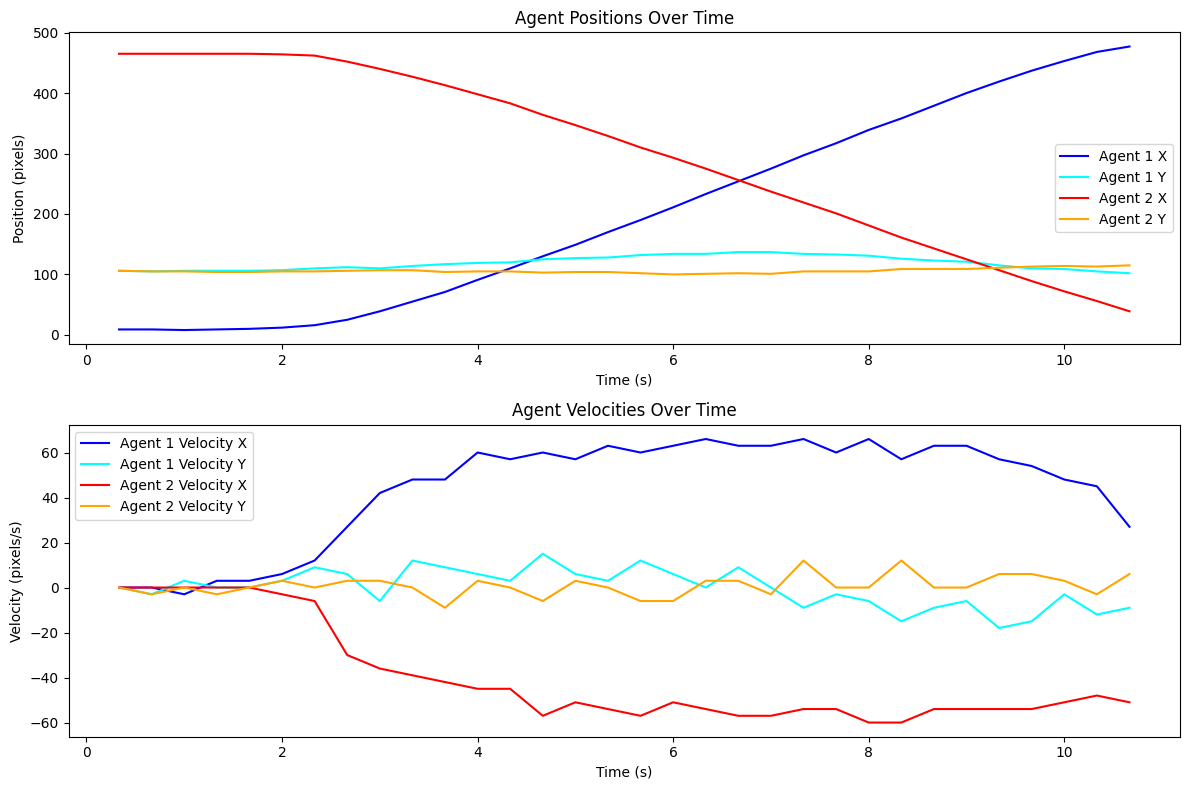

In [13]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load video
video_path = r"F:\Thesis\LARGE-SCALE-CROWD-SIMULATION\head_on.mp4"
cap = cv2.VideoCapture(video_path)

# HSV range for red color
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Parameters for velocity calculation
prev_agent1 = None  # Changed from prev_positions
prev_agent2 = None  # Changed from prev_positions
positions = []
velocities = []
timestamps = []

# Frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = 10  # Added frame_interval
delta_time = frame_interval / fps  # Modified delta_time

frame_counter = 0  # Added frame_counter

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_counter += 1  # Increment frame_counter

    if frame_counter % frame_interval == 0:  # Store positions at intervals
        # Convert to HSV
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create mask for red color
        mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(mask1, mask2)

        # Find contours
        contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find centers of the two largest contours (agents)
        centers = []
        for contour in sorted(contours, key=cv2.contourArea, reverse=True)[:2]:
            M = cv2.moments(contour)
            if M["m00"] > 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centers.append((cx, cy))

        # Ensure we have two centers
        if len(centers) == 2:
            if prev_agent1 is None and prev_agent2 is None:
                # Initial assignment
                prev_agent1, prev_agent2 = centers
            else:
                # Calculate distances to previous agents
                dist_agent1 = np.linalg.norm(np.array(centers) - np.array(prev_agent1), axis=1)
                dist_agent2 = np.linalg.norm(np.array(centers) - np.array(prev_agent2), axis=1)

                # Assign closest center to agent1
                if dist_agent1[0] + dist_agent2[1] <= dist_agent1[1] + dist_agent2[0]:
                    agent1, agent2 = centers[0], centers[1]
                else:
                    agent1, agent2 = centers[1], centers[0]

                prev_agent1, prev_agent2 = agent1, agent2

            positions.append([prev_agent1, prev_agent2])

            # Append the timestamp
            timestamps.append(len(positions) * delta_time)

            # Calculate velocity if previous positions exist
            if len(positions) > 1:
                velocity_agent1 = (
                    (prev_agent1[0] - positions[-2][0][0]) / delta_time,
                    (prev_agent1[1] - positions[-2][0][1]) / delta_time,
                )
                velocity_agent2 = (
                    (prev_agent2[0] - positions[-2][1][0]) / delta_time,
                    (prev_agent2[1] - positions[-2][1][1]) / delta_time,
                )
                velocities.append([velocity_agent1, velocity_agent2])
            else:
                velocities.append([(0, 0), (0, 0)])  # Initial velocity

            # Display tracking
            cv2.circle(frame, prev_agent1, 5, (0, 255, 0), -1)
            cv2.circle(frame, prev_agent2, 5, (0, 255, 0), -1)

    cv2.imshow("Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Save positions and velocities
# df = pd.DataFrame({
#     "Timestamp": timestamps,
#     "Position_Agent1": [pos[0] for pos in positions],
#     "Position_Agent2": [pos[1] for pos in positions],
#     "Velocity_Agent1": [vel[0] for vel in velocities],
#     "Velocity_Agent2": [vel[1] for vel in velocities]
# })
# df.to_csv("agent_positions_and_velocities.csv", index=False)
# print("Tracking completed. Data saved to 'agent_positions_and_velocities.csv'.")

# Extract data for plotting
timestamps = np.array(timestamps)
positions_agent1 = np.array([pos[0] for pos in positions])
positions_agent2 = np.array([pos[1] for pos in positions])
velocities_agent1 = np.array([vel[0] for vel in velocities])
velocities_agent2 = np.array([vel[1] for vel in velocities])

# Plot positions and velocities
plt.figure(figsize=(12, 8))

# Plot positions
plt.subplot(2, 1, 1)
plt.plot(timestamps, positions_agent1[:, 0], label="Agent 1 X", color="blue")
plt.plot(timestamps, positions_agent1[:, 1], label="Agent 1 Y", color="cyan")
plt.plot(timestamps, positions_agent2[:, 0], label="Agent 2 X", color="red")
plt.plot(timestamps, positions_agent2[:, 1], label="Agent 2 Y", color="orange")
plt.title("Agent Positions Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Position (pixels)")
plt.legend()

# Plot velocities
plt.subplot(2, 1, 2)
plt.plot(timestamps, velocities_agent1[:, 0], label="Agent 1 Velocity X", color="blue")
plt.plot(timestamps, velocities_agent1[:, 1], label="Agent 1 Velocity Y", color="cyan")
plt.plot(timestamps, velocities_agent2[:, 0], label="Agent 2 Velocity X", color="red")
plt.plot(timestamps, velocities_agent2[:, 1], label="Agent 2 Velocity Y", color="orange")
plt.title("Agent Velocities Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (pixels/s)")
plt.legend()

plt.tight_layout()
plt.show()

#save the (x,y) pixel values only for the agents in a csv file with timestamp
data = pd.DataFrame({
    "time": timestamps,
    "x_pos_1": positions_agent1[:, 0],
    "y_pos_1": positions_agent1[:, 1],
    "x_pos_2": positions_agent2[:, 0],
    "y_pos_2": positions_agent2[:, 1]
})
data.to_csv("F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\agent_positions_and_velocities_complete.csv", index=False)

In [14]:
print(len(data))

32


Initial Assignment: Agent1=(8, 106), Agent2=(465, 106)
Assigned: Agent1=(9, 106), Agent2=(465, 106)
Assigned: Agent1=(9, 105), Agent2=(465, 105)
Assigned: Agent1=(9, 105), Agent2=(465, 105)
Assigned: Agent1=(8, 105), Agent2=(465, 105)
Assigned: Agent1=(8, 106), Agent2=(465, 105)
Assigned: Agent1=(9, 106), Agent2=(465, 104)
Assigned: Agent1=(9, 106), Agent2=(465, 104)
Assigned: Agent1=(9, 106), Agent2=(465, 104)
Assigned: Agent1=(10, 106), Agent2=(465, 104)
Assigned: Agent1=(11, 106), Agent2=(464, 105)
Assigned: Agent1=(12, 107), Agent2=(464, 105)
Assigned: Agent1=(13, 108), Agent2=(463, 105)
Assigned: Agent1=(16, 110), Agent2=(462, 105)
Assigned: Agent1=(19, 111), Agent2=(458, 105)
Assigned: Agent1=(25, 112), Agent2=(452, 106)
Assigned: Agent1=(32, 111), Agent2=(446, 107)
Assigned: Agent1=(39, 110), Agent2=(440, 107)
Assigned: Agent1=(47, 111), Agent2=(434, 107)
Assigned: Agent1=(55, 114), Agent2=(427, 107)
Assigned: Agent1=(64, 116), Agent2=(420, 105)
Assigned: Agent1=(71, 117), Agent

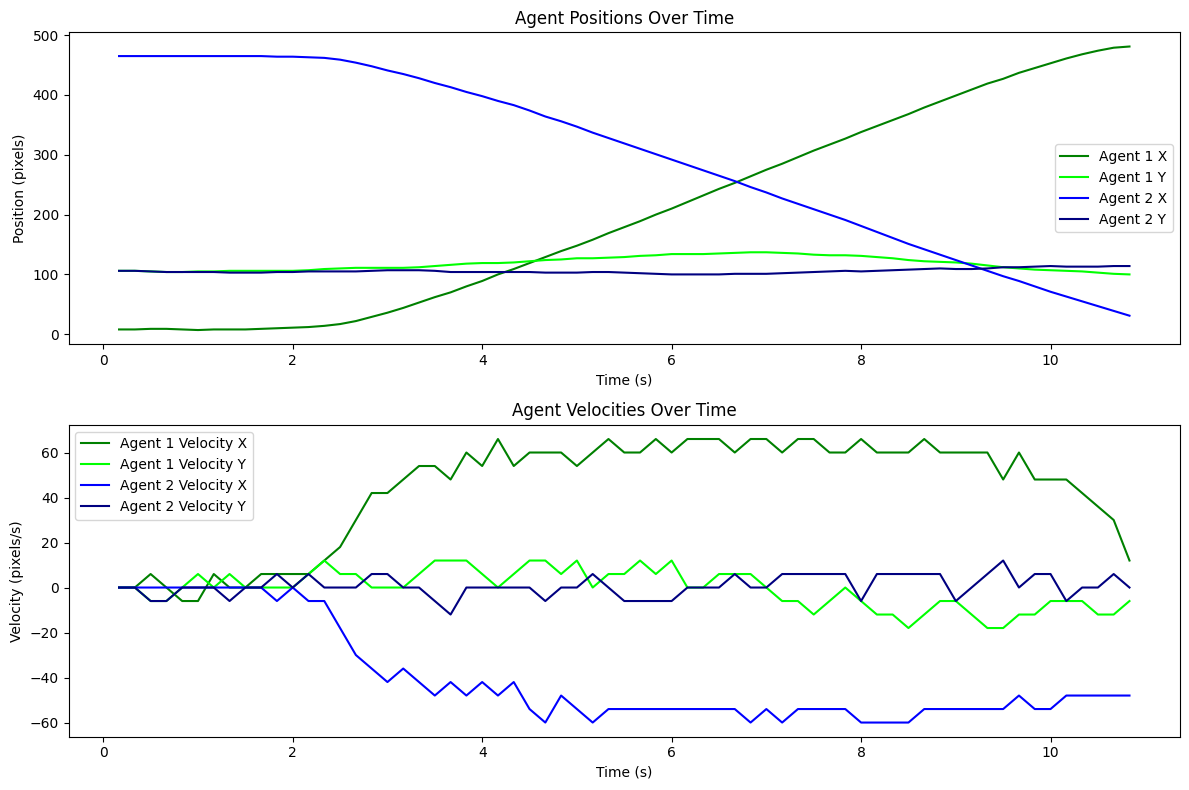

In [27]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define Kalman Filter class
class KalmanFilter:
    def __init__(self, x, y, q=1, r=10):
        # State vector [x, y, dx, dy]
        self.state = np.array([x, y, 0, 0], dtype=float)
        # State covariance
        self.P = np.eye(4) * 500
        # Transition matrix
        self.F = np.array([[1, 0, 1, 0],
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=float)
        # Measurement matrix
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]], dtype=float)
        # Measurement covariance
        self.R = np.eye(2) * r  # Adjustable parameter
        # Process covariance
        self.Q = np.eye(4) * q  # Adjustable parameter
    
    def predict(self):
        self.state = self.F @ self.state
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.state[:2]
    
    def update(self, z):
        y = z - (self.H @ self.state)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.state = self.state + K @ y
        I = np.eye(4)
        self.P = (I - K @ self.H) @ self.P

# Load video
video_path = r"F:\Thesis\LARGE-SCALE-CROWD-SIMULATION\head_on.mp4"
cap = cv2.VideoCapture(video_path)

# HSV range for red color
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Parameters for velocity calculation
positions = []
velocities = []
timestamps = []

# Initialize Kalman Filters
kalman_agent1 = None
kalman_agent2 = None

# Frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = 5  # Adjust as needed
delta_time = frame_interval / fps

frame_counter = 0

# Define frame dimensions
frame_height = 272
frame_width = 480

# Calculate the midline
mid_y = frame_height // 2

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_counter += 1

    if frame_counter % frame_interval == 0:
        # Convert to HSV
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create mask for red color
        mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(mask1, mask2)

        # Find contours
        contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find centers of the two largest contours (agents) with their area
        centers = []
        for contour in sorted(contours, key=cv2.contourArea, reverse=True)[:2]:
            M = cv2.moments(contour)
            if M["m00"] > 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])  # Use actual y-coordinate from moments
                area = cv2.contourArea(contour)
                centers.append((cx, cy, area))

        # Predict next positions
        if kalman_agent1 and kalman_agent2:
            pred1 = kalman_agent1.predict()
            pred2 = kalman_agent2.predict()
        else:
            pred1, pred2 = None, None

        # Assign detections to agents
        if len(centers) == 2:
            if kalman_agent1 is None and kalman_agent2 is None:
                # Initial assignment based on left and right positions
                if centers[0][0] < centers[1][0]:
                    kalman_agent1 = KalmanFilter(centers[0][0], centers[0][1], q=1, r=10)
                    kalman_agent2 = KalmanFilter(centers[1][0], centers[1][1], q=1, r=10)
                    assignment = f"Initial Assignment: Agent1={centers[0][:2]}, Agent2={centers[1][:2]}"
                else:
                    kalman_agent1 = KalmanFilter(centers[1][0], centers[1][1], q=1, r=10)
                    kalman_agent2 = KalmanFilter(centers[0][0], centers[0][1], q=1, r=10)
                    assignment = f"Initial Assignment: Agent1={centers[1][:2]}, Agent2={centers[0][:2]}"
                print(assignment)
            else:
                # Compute distances to predictions
                distances = np.array([
                    np.linalg.norm(np.array(centers[0][:2]) - pred1),
                    np.linalg.norm(np.array(centers[0][:2]) - pred2),
                    np.linalg.norm(np.array(centers[1][:2]) - pred1),
                    np.linalg.norm(np.array(centers[1][:2]) - pred2)
                ]).reshape(2,2)

                # Assign based on minimal distance
                if distances[0][0] + distances[1][1] <= distances[0][1] + distances[1][0]:
                    kalman_agent1.update(np.array(centers[0][:2]))
                    kalman_agent2.update(np.array(centers[1][:2]))
                    assignment = f"Assigned: Agent1={centers[0][:2]}, Agent2={centers[1][:2]}"
                else:
                    kalman_agent1.update(np.array(centers[1][:2]))
                    kalman_agent2.update(np.array(centers[0][:2]))
                    assignment = f"Assigned: Agent1={centers[1][:2]}, Agent2={centers[0][:2]}"
                
                print(assignment)

        # Append positions and velocities only if both agents are detected
        if kalman_agent1 and kalman_agent2 and len(centers) == 2:
            pos1 = kalman_agent1.state[:2].astype(int)
            pos2 = kalman_agent2.state[:2].astype(int)
            positions.append([tuple(pos1), tuple(pos2)])

            # Append timestamp
            timestamps.append(len(positions) * delta_time)

            # Calculate velocities
            if len(positions) > 1:
                velocity_agent1 = (
                    (pos1[0] - positions[-2][0][0]) / delta_time,
                    (pos1[1] - positions[-2][0][1]) / delta_time,
                )
                velocity_agent2 = (
                    (pos2[0] - positions[-2][1][0]) / delta_time,
                    (pos2[1] - positions[-2][1][1]) / delta_time,
                )
                velocities.append([velocity_agent1, velocity_agent2])
            else:
                velocities.append([(0, 0), (0, 0)])  # Initial velocity

            # Display tracking with distinct colors
            cv2.circle(frame, tuple(pos1), 5, (0, 255, 0), -1)  # Green for Agent 1
            cv2.circle(frame, tuple(pos2), 5, (255, 0, 0), -1)  # Blue for Agent 2

    cv2.imshow("Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Save positions and velocities only when both agents are detected
df = pd.DataFrame({
    "Timestamp": timestamps,
    "Position_Agent1": [pos[0] for pos in positions],
    "Position_Agent2": [pos[1] for pos in positions],
    "Velocity_Agent1": [vel[0] for vel in velocities],
    "Velocity_Agent2": [vel[1] for vel in velocities]
})
# df.to_csv("agent_positions_and_velocities.csv", index=False)
# print("Tracking completed. Data saved to 'agent_positions_and_velocities.csv'.")

# Extract data for plotting
timestamps_np = np.array(timestamps)
positions_agent1 = np.array([pos[0] for pos in positions])
positions_agent2 = np.array([pos[1] for pos in positions])
velocities_agent1 = np.array([vel[0] for vel in velocities])
velocities_agent2 = np.array([vel[1] for vel in velocities])

# Plot positions and velocities
plt.figure(figsize=(12, 8))

# Plot positions
plt.subplot(2, 1, 1)
plt.plot(timestamps_np, positions_agent1[:, 0], label="Agent 1 X", color="green")
plt.plot(timestamps_np, positions_agent1[:, 1], label="Agent 1 Y", color="lime")
plt.plot(timestamps_np, positions_agent2[:, 0], label="Agent 2 X", color="blue")
plt.plot(timestamps_np, positions_agent2[:, 1], label="Agent 2 Y", color="navy")
plt.title("Agent Positions Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Position (pixels)")
plt.legend()

# Plot velocities
plt.subplot(2, 1, 2)
plt.plot(timestamps_np, velocities_agent1[:, 0], label="Agent 1 Velocity X", color="green")
plt.plot(timestamps_np, velocities_agent1[:, 1], label="Agent 1 Velocity Y", color="lime")
plt.plot(timestamps_np, velocities_agent2[:, 0], label="Agent 2 Velocity X", color="blue")
plt.plot(timestamps_np, velocities_agent2[:, 1], label="Agent 2 Velocity Y", color="navy")
plt.title("Agent Velocities Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (pixels/s)")
plt.legend()

plt.tight_layout()
plt.show()

# Save the (x,y) pixel values only for the agents in a CSV file with timestamp
data = pd.DataFrame({
    "time": timestamps_np,
    "x_pos_1": positions_agent1[:, 0],
    "y_pos_1": positions_agent1[:, 1],
    "x_pos_2": positions_agent2[:, 0],
    "y_pos_2": positions_agent2[:, 1]
})
# data.to_csv("F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\agent_positions_and_velocities_complete.csv", index=False)
# print("Complete agent positions saved to 'agent_positions_and_velocities_complete.csv'.")

# Complete Tracking Code Using Hungarian Algorithm for Optimal Assignment

Initialized Agent with position: (8, 106)
Initialized Agent with position: (465, 106)
Assigned: Detection (9, 106) to Agent 1
Assigned: Detection (465, 106) to Agent 2
Assigned: Detection (9, 105) to Agent 1
Assigned: Detection (465, 105) to Agent 2
Assigned: Detection (9, 105) to Agent 1
Assigned: Detection (465, 105) to Agent 2
Assigned: Detection (8, 105) to Agent 1
Assigned: Detection (465, 105) to Agent 2
Assigned: Detection (8, 106) to Agent 1
Assigned: Detection (465, 105) to Agent 2
Assigned: Detection (9, 106) to Agent 1
Assigned: Detection (465, 104) to Agent 2
Assigned: Detection (9, 106) to Agent 1
Assigned: Detection (465, 104) to Agent 2
Assigned: Detection (9, 106) to Agent 1
Assigned: Detection (465, 104) to Agent 2
Assigned: Detection (10, 106) to Agent 1
Assigned: Detection (465, 104) to Agent 2
Assigned: Detection (11, 106) to Agent 1
Assigned: Detection (464, 105) to Agent 2
Assigned: Detection (12, 107) to Agent 1
Assigned: Detection (464, 105) to Agent 2
Assigned:

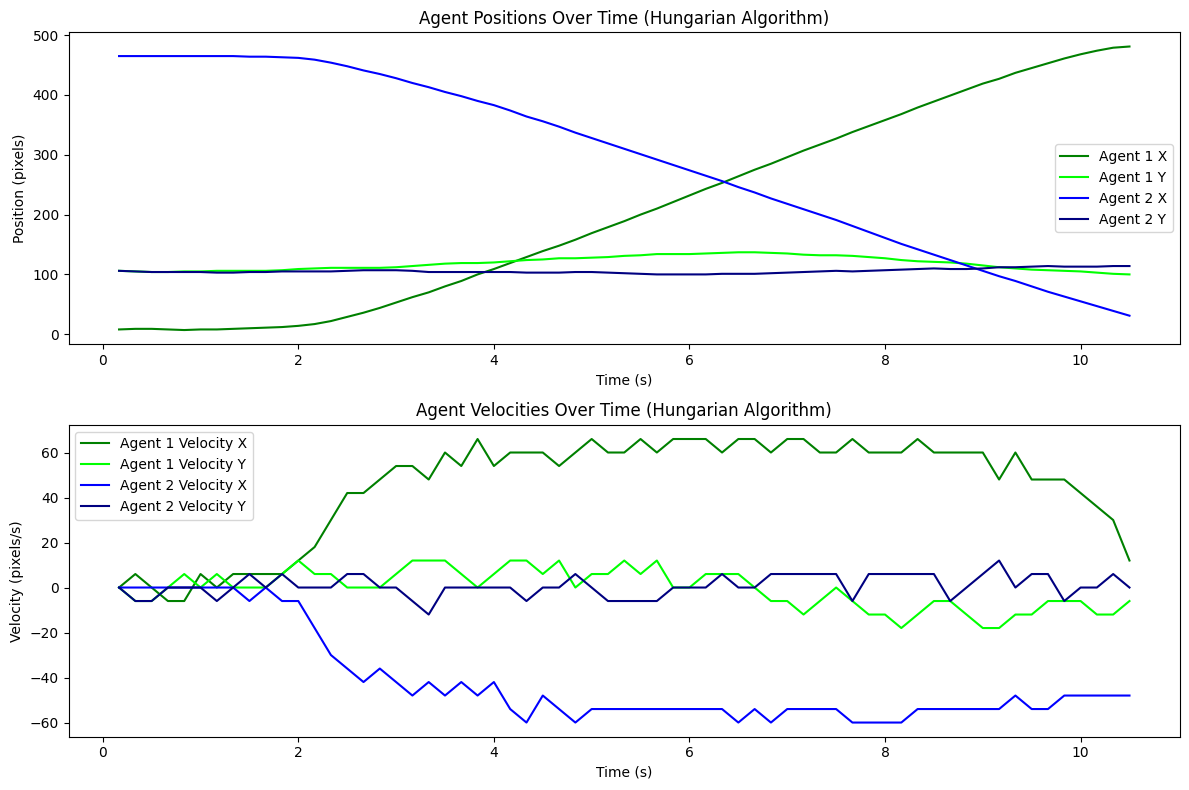

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Define Kalman Filter class
class KalmanFilter:
    def __init__(self, x, y, q=1, r=10):
        # State vector [x, y, dx, dy]
        self.state = np.array([x, y, 0, 0], dtype=float)
        # State covariance
        self.P = np.eye(4) * 500
        # Transition matrix
        self.F = np.array([[1, 0, 1, 0],
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=float)
        # Measurement matrix
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]], dtype=float)
        # Measurement covariance
        self.R = np.eye(2) * r  # Adjustable parameter
        # Process covariance
        self.Q = np.eye(4) * q  # Adjustable parameter
    
    def predict(self):
        self.state = self.F @ self.state
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.state[:2]
    
    def update(self, z):
        y = z - (self.H @ self.state)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.state = self.state + K @ y
        I = np.eye(4)
        self.P = (I - K @ self.H) @ self.P

# Load video
video_path = r"F:\Thesis\LARGE-SCALE-CROWD-SIMULATION\head_on.mp4"
cap = cv2.VideoCapture(video_path)

# HSV range for red color
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Parameters for velocity calculation
positions = []
velocities = []
timestamps = []

# Initialize Kalman Filters for agents
kalman_filters = []

# Number of agents to track
num_agents = 2

# Frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = 5  # Adjust as needed
delta_time = frame_interval / fps

frame_counter = 0

# Define frame dimensions
frame_height = 272
frame_width = 480

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_counter += 1

    if frame_counter % frame_interval == 0:
        # Convert to HSV
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create mask for red color
        mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(mask1, mask2)

        # Find contours
        contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find centers of contours with their area
        detected_centers = []
        for contour in sorted(contours, key=cv2.contourArea, reverse=True)[:num_agents]:
            M = cv2.moments(contour)
            if M["m00"] > 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                area = cv2.contourArea(contour)
                detected_centers.append((cx, cy, area))

        predicted_positions = []
        for kf in kalman_filters:
            pred = kf.predict()
            predicted_positions.append(pred)

        # Assign detections to agents using Hungarian Algorithm
        if len(detected_centers) == num_agents and len(predicted_positions) == num_agents:
            cost_matrix = np.zeros((num_agents, num_agents), dtype=float)
            for i in range(num_agents):
                for j in range(num_agents):
                    # Compute Euclidean distance
                    distance = np.linalg.norm(np.array(detected_centers[i][:2]) - predicted_positions[j])
                    cost_matrix[i][j] = distance

            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            # Update Kalman Filters with assigned detections
            for i in range(len(row_ind)):
                detection_idx = row_ind[i]
                agent_idx = col_ind[i]
                detected_center = detected_centers[detection_idx]
                kalman_filters[agent_idx].update(np.array(detected_center[:2]))
                print(f"Assigned: Detection {detected_center[:2]} to Agent {agent_idx+1}")

        elif len(detected_centers) > 0 and len(kalman_filters) < num_agents:
            # Initialize Kalman Filters for new detections
            for center in detected_centers:
                kalman_filters.append(KalmanFilter(center[0], center[1], q=1, r=10))
                print(f"Initialized Agent with position: {center[:2]}")
                if len(kalman_filters) == num_agents:
                    break
        else:
            # If detections are missing, rely on predictions
            print("Detections missing for some agents. Relying on predictions.")

        # Append positions and velocities only if all agents have been initialized
        if len(kalman_filters) == num_agents and len(detected_centers) >= num_agents:
            agent_positions = [kf.state[:2].astype(int) for kf in kalman_filters]
            positions.append([tuple(pos) for pos in agent_positions])

            # Append timestamp
            timestamps.append(len(positions) * delta_time)

            # Calculate velocities
            if len(positions) > 1:
                velocity_frame = []
                for idx in range(num_agents):
                    vx = (agent_positions[idx][0] - positions[-2][idx][0]) / delta_time
                    vy = (agent_positions[idx][1] - positions[-2][idx][1]) / delta_time
                    velocity_frame.append((vx, vy))
                velocities.append(velocity_frame)
            else:
                velocities.append([ (0,0) for _ in range(num_agents) ])  # Initial velocity

            # Display tracking with distinct colors
            colors = [(0, 255, 0), (255, 0, 0)]  # Green for Agent1, Blue for Agent2
            for idx, pos in enumerate(agent_positions):
                cv2.circle(frame, tuple(pos), 5, colors[idx], -1)

    cv2.imshow("Tracking with Hungarian Algorithm", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Save positions and velocities only when all agents are detected
df = pd.DataFrame({
    "Timestamp": timestamps,
    "Position_Agent1": [pos[0] for pos in positions],
    "Position_Agent2": [pos[1] for pos in positions],
    "Velocity_Agent1": [vel[0] for vel in velocities],
    "Velocity_Agent2": [vel[1] for vel in velocities]
})
# df.to_csv("agent_positions_and_velocities_hungarian.csv", index=False)
# print("Tracking with Hungarian Algorithm completed. Data saved to 'agent_positions_and_velocities_hungarian.csv'.")

# Extract data for plotting
timestamps_np = np.array(timestamps)
positions_agent1 = np.array([pos[0] for pos in positions])
positions_agent2 = np.array([pos[1] for pos in positions])
velocities_agent1 = np.array([vel[0] for vel in velocities])
velocities_agent2 = np.array([vel[1] for vel in velocities])

# Plot positions and velocities
plt.figure(figsize=(12, 8))

# Plot positions
plt.subplot(2, 1, 1)
plt.plot(timestamps_np, positions_agent1[:, 0], label="Agent 1 X", color="green")
plt.plot(timestamps_np, positions_agent1[:, 1], label="Agent 1 Y", color="lime")
plt.plot(timestamps_np, positions_agent2[:, 0], label="Agent 2 X", color="blue")
plt.plot(timestamps_np, positions_agent2[:, 1], label="Agent 2 Y", color="navy")
plt.title("Agent Positions Over Time (Hungarian Algorithm)")
plt.xlabel("Time (s)")
plt.ylabel("Position (pixels)")
plt.legend()

# Plot velocities
plt.subplot(2, 1, 2)
plt.plot(timestamps_np, velocities_agent1[:, 0], label="Agent 1 Velocity X", color="green")
plt.plot(timestamps_np, velocities_agent1[:, 1], label="Agent 1 Velocity Y", color="lime")
plt.plot(timestamps_np, velocities_agent2[:, 0], label="Agent 2 Velocity X", color="blue")
plt.plot(timestamps_np, velocities_agent2[:, 1], label="Agent 2 Velocity Y", color="navy")
plt.title("Agent Velocities Over Time (Hungarian Algorithm)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (pixels/s)")
plt.legend()

plt.tight_layout()
plt.show()

# Save the (x,y) pixel values only for the agents in a CSV file with timestamp
data = pd.DataFrame({
    "time": timestamps_np,
    "x_pos_1": positions_agent1[:, 0],
    "y_pos_1": positions_agent1[:, 1],
    "x_pos_2": positions_agent2[:, 0],
    "y_pos_2": positions_agent2[:, 1]
})
# data.to_csv("F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\agent_positions_and_velocities_hungarian_complete.csv", index=False)
# print("Complete agent positions with Hungarian Algorithm saved to 'agent_positions_and_velocities_hungarian_complete.csv'.")

In [65]:
data.head(-1)

,time,x_pos_1,y_pos_1,x_pos_2,y_pos_2,real_x_1,real_y_1,real_x_2,real_y_2
0,0.166657,8,106,465,106,0.167,1.364,9.688,1.364
1,0.333313,8,106,465,106,0.167,1.364,9.688,1.364
2,0.499970,9,105,465,105,0.188,1.351,9.688,1.351
3,0.666626,9,104,465,104,0.188,1.338,9.688,1.338
4,0.833283,8,104,465,104,0.167,1.338,9.688,1.338
...,...,...,...,...,...,...,...,...,...
59,9.999392,453,107,71,114,9.438,1.377,1.479,1.467
60,10.166049,461,106,63,113,9.604,1.364,1.312,1.454
61,10.332705,468,105,55,113,9.750,1.351,1.146,1.454
62,10.499362,474,103,47,113,9.875,1.325,0.979,1.454


In [15]:
import pandas as pd
import numpy as np

# Read the existing CSV file
data = pd.read_csv('F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\agent_positions_and_velocities_complete.csv')

# Convert pixel values to real-world coordinates
data['real_x_1'] = np.round((data['x_pos_1'] / 480) * 10, 3)
data['real_y_1'] = np.round((data['y_pos_1'] / 272) * 3.5, 3)
data['real_x_2'] = np.round((data['x_pos_2'] / 480) * 10, 3)
data['real_y_2'] = np.round((data['y_pos_2'] / 272) * 3.5, 3)

# Create a new dataframe with the timestamp in the first column
new_data = pd.DataFrame({
    'time': data['time'],  # Assuming 'times' is the column with timestamps
    'real_x_1': data['real_x_1'],
    'real_y_1': data['real_y_1'],
    'real_x_2': data['real_x_2'],
    'real_y_2': data['real_y_2']
})

# Save the new data with real-world coordinates to a new CSV file
#new_data.to_csv('new_converted_coordinates_with_time.csv', index=False)

print("CSV file with real-world coordinates and time stamps saved.")


CSV file with real-world coordinates and time stamps saved.


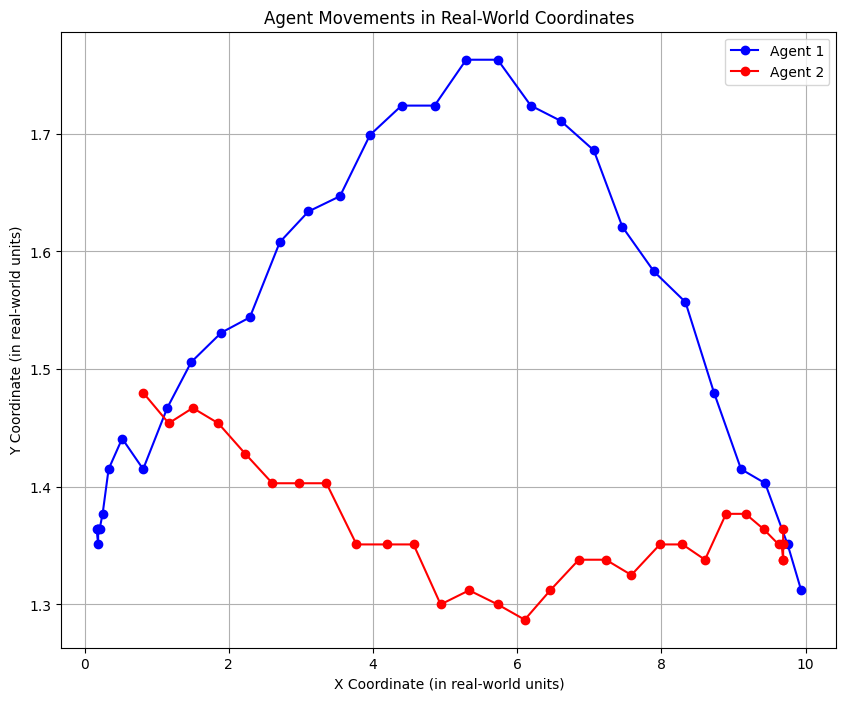

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file with timestamps and real-world coordinates
# data = pd.read_csv('/content/new_converted_coordinates_with_time.csv')

# Plot the trajectories of both agents
plt.figure(figsize=(10, 8))

# Agent 1's trajectory
plt.plot(new_data['real_x_1'], new_data['real_y_1'], label='Agent 1', marker='o', color='b')

# Agent 2's trajectory
plt.plot(new_data['real_x_2'], new_data['real_y_2'], label='Agent 2', marker='o', color='r')

# Adding labels and title
plt.title('Agent Movements in Real-World Coordinates')
plt.xlabel('X Coordinate (in real-world units)')
plt.ylabel('Y Coordinate (in real-world units)')

# Adding a legend to differentiate between agents
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [17]:
import pandas as pd
import numpy as np

# Load the CSV file containing positions and times
# data = pd.read_csv('/content/new_converted_coordinates_with_time.csv')

# Extract data for both agents
time = new_data['time'].values
x_pos_1 = new_data['real_x_1'].values
y_pos_1 = new_data['real_y_1'].values
x_pos_2 = new_data['real_x_2'].values
y_pos_2 = new_data['real_y_2'].values

# Initialize lists to store velocities with 0 for the first two entries
v_x1 = [0, 0]
v_y1 = [0, 0]
v_x2 = [0, 0]
v_y2 = [0, 0]

# Loop through the positions using the central difference formula
for i in range(2, len(time) - 2):
    h = (time[i + 2] - time[i])
    # print(h,x_pos_1[i + 2],x_pos_1[i + 1],x_pos_1[i - 1],x_pos_1[i - 2])
    # print(h,time[i+2],time[i])
    # Agent 1
    vx1 = (-x_pos_1[i + 2] + 8 * x_pos_1[i + 1] - 8 * x_pos_1[i - 1] + x_pos_1[i - 2]) / (12 * h)
    vy1 = (-y_pos_1[i + 2] + 8 * y_pos_1[i + 1] - 8 * y_pos_1[i - 1] + y_pos_1[i - 2]) / (12 * h)

    v_x1.append(round(abs(vx1), 2))  # Take absolute value and round to 2 decimals
    v_y1.append(round(abs(vy1), 2))

    # Agent 2
    vx2 = (-x_pos_2[i + 2] + 8 * x_pos_2[i + 1] - 8 * x_pos_2[i - 1] + x_pos_2[i - 2]) / (12 * h)
    vy2 = (-y_pos_2[i + 2] + 8 * y_pos_2[i + 1] - 8 * y_pos_2[i - 1] + y_pos_2[i - 2]) / (12 * h)

    v_x2.append(round((vx2), 2))
    v_y2.append(round((vy2), 2))

# Append 0 for the last two entries
v_x1.extend([0, 0])
v_y1.extend([0, 0])
v_x2.extend([0, 0])
v_y2.extend([0, 0])

# Save the results in a new CSV file, matching the position rows
output_data = pd.DataFrame({
    'time': time,  # Use all time values
    'x_pos_1': x_pos_1,
    'y_pos_1': y_pos_1,
    'v_x1': v_x1,
    'v_y1': v_y1,
    'x_pos_2': x_pos_2,
    'y_pos_2': y_pos_2,
    'v_x2': v_x2,
    'v_y2': v_y2
})

# Ensure the data is sorted by the 'time' column
output_data = output_data.sort_values(by='time')

# Save to a new CSV file with two decimal precision
output_data.to_csv('F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\simulation_agent_positions_and_velocities_complete.csv', index=False, float_format='%.2f')

print("Data saved to 'agent_positions_and_velocities_complete.csv'")


Data saved to 'agent_positions_and_velocities_complete.csv'


In [65]:
import pandas as pd
import numpy as np

# Read the CSV file
# new_data = pd.read_csv(r'C:\Users\harsh\Downloads\new_converted_coordinates_with_time.csv')

delta_t = 5/30

# Calculate Euclidean distance for Agent 1
df['agent1_velocity'] = np.sqrt(new_data['real_x_1'].diff()**2 + new_data['real_y_1'].diff()**2) / delta_time

# Calculate Euclidean distance for Agent 2
df['agent2_velocity'] = np.sqrt(new_data['real_x_2'].diff()**2 + new_data['real_y_2'].diff()**2) / delta_time

# Fill NaN values resulting from the diff() operation
df.fillna(0, inplace=True)

# Save the updated dataframe to a new CSV file
df.to_csv(r'C:\Users\harsh\Downloads\new_velocity_coordinates_with_time.csv', index=False)

In [31]:
df.head()

,time,real_x_1,real_y_1,real_x_2,real_y_2,agent1_velocity,agent2_velocity
0,0.166657,0.167,1.364,9.688,1.364,0.00,0.00
1,0.333313,0.188,1.364,9.688,1.364,0.63,0.00
2,0.499970,0.188,1.351,9.688,1.351,0.39,0.39
3,0.666626,0.188,1.351,9.688,1.351,0.00,0.00
4,0.833283,0.167,1.351,9.688,1.351,0.63,0.00
